# 1 Relay Control using Simpy

## Why Simpy?

[Simpy](https://simpy.readthedocs.io/en/latest/) is a python package for discrete event simulation package. The package includes tools for controlling event driven models. Simpy also includes a [real-time simulation environment[(http://simpy.readthedocs.io/en/latest/topical_guides/real-time-simulations.html) which makes it dead simple to construct process control algorithms that interface with the Temperature Control Lab.

In [12]:
import simpy.rt
import sys
sys.path.append("../TCLab")
from TCLab import TCLab

# control coroutine
def observe(env):
    while True:
        print('{0:3d}  T1={1:5.1f} T2={2:5.1f}'.format(env.now,a.T1,a.T2))
        yield env.timeout(5)

# start up TC Lab
a = TCLab()
a.start

# turn heater to 100
a.Q1 = 100
        
# let simpy handle all of the timing and syncronization stuff
env = simpy.rt.RealtimeEnvironment(strict=False)
env.process(observe(env))
env.run(until=100)

# shut down TCLab
a.stop

Opening connection
TCLab connected via Arduino on port /dev/tty.wchusbserial1410
  0  T1= 25.4 T2= 23.5
  5  T1= 25.4 T2= 23.5
 10  T1= 25.7 T2= 23.5
 15  T1= 25.7 T2= 23.5
 20  T1= 26.1 T2= 23.8
 25  T1= 26.1 T2= 23.5
 30  T1= 25.7 T2= 23.5
 35  T1= 26.1 T2= 23.8
 40  T1= 26.1 T2= 23.8
 45  T1= 26.1 T2= 23.5
 50  T1= 26.1 T2= 23.5
 55  T1= 26.1 T2= 23.8
 60  T1= 25.7 T2= 23.8
 65  T1= 26.1 T2= 23.8
 70  T1= 25.7 T2= 23.5
 75  T1= 25.7 T2= 23.8
 80  T1= 26.1 T2= 23.8
 85  T1= 25.7 T2= 23.5
 90  T1= 26.1 T2= 23.8
 95  T1= 25.7 T2= 23.8


<bound method TCLab.stop of <TCLab.TCLab object at 0x122b84a90>>

## Simple Relay Control

The following code implements relay control for temperature T1 on the Temperature Control Lab.

\begin{align}
Q(t) & = \begin{cases} 
    Q^{max} &\text{if $T \leq T_{setpoint}$}\\
    0       & \text{if $T \geq T_{setpoint}$}
    \end{cases}
\end{align}

This is simple to implement, in fact it is just one line of code in the following cell. Adjust `Tsetpoint` to a desired setpoint value, then run the cell.

This cell also adds a few extra features. The most important is to use try/except to catch keyboard interrupts. (Esc - i - i in Jupyter notebooks). If the cell is interrupted, then the except branch makes sure the TCLab is shut down upon exit.

The second feature is to break up the control and reporting functions. In this case the control loop has been adjusted to sample every second, but reporter only updates every five seconds. The print statement uses a few features to keep the display to a single line, to flush the print buffer to Jupyter so that it is seen immediately. These are two useful tricks to know when using Jupyter for interactive work.

Opening connection
TCLab connected via Arduino on port /dev/tty.wchusbserial1410

  Time(sec)   Heater(mV)   Temp(deg C)


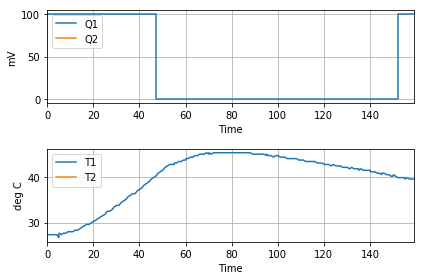

In [4]:
%matplotlib inline

import simpy.rt
import sys
sys.path.append("../TCLab")
from TCLab import TCLab

# controller coroutine with interrupt for premature ending
def control(env):
    while True:
        try:
            a.Q1 = 100 if a.T1 <= Tsetpoint else 0
            yield env.timeout(1)
        except:
            a.stop()
            
# reporter coroutine to help us monitor status
def reporter(env):
    print("\n  Time(sec)   Heater(mV)   Temp(deg C)")
    sfmt = '  {0:7.2f}      {1:7.2f}     {2:7.2f}'
    while True:
        print(sfmt.format(env.now, a.Q1, a.T1), flush=True, end='\r')
        yield env.timeout(5)

# fix the setpoint
Tsetpoint = 40.0

# start up the temperature control lab
a = TCLab()
a.start()

# create the real-time simulation environment
env = simpy.rt.RealtimeEnvironment(strict=False)
env.process(control(env))
env.process(reporter(env))
env.run(until=160)

# shutdown 
a.stop()
a.plot()

## Relay Control with Hysteresis

One of the issues with simple relay control is the potential for 'chattering', which are situations where the manipulated variable (in this case heater power) rapid on-and-off switching. This can be caused by systems that are highly response to control inputs or where the sensor measurements carry significant noise.

The typical home thermostat used for furnace control incorporates a simple but highly effective solution to the chattering period. The idea is to intentially overshoot the setpoint. Then, after the control switches state, there will be at least a short period of time where no further control action should be necessary. The control algorithm can be written

\begin{align}
Q(t) & = \begin{cases} 
    Q^{max} &\text{if $T \leq T_{Setpoint} + \frac{h}{2}$}\\
    0       & \text{if $T \geq T_{Setpoint} - \frac{h}{2}$}
    \end{cases}
\end{align}

where $h$ is the *tolerance* or *hysteresis*. For home heating systems a typical value is 0.5 to 1 degree F. This image shows how hystersis was adjusted on a typical home thermostat in common usage in the late 20th century.

<img src="../images/515px-Honeywell_thermostat_open.jpg" style="width: 300px;"></img>

Image by <a href="//commons.wikimedia.org/wiki/User:Vdegroot" title="User:Vdegroot">Vincent de Groot</a> - <a rel="nofollow" class="external free" href="http://www.videgro.net">http://www.videgro.net</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by/2.5" title="Creative Commons Attribution 2.5">CC BY 2.5</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=902832">Link</a>

The furnance is turned on for temperatures below the range 

\begin{align}
T_{Setpoint} - \frac{h}{2} \leq T \leq T_{Setpoint} + \frac{h}{2}
\end{align}

and is turned for temperatures above the range. Within the range, however, the furnance may be on or off, depending on what happened at the last decision point.


The following code implements relay control with hystersis.

Opening connection
TCLab connected via Arduino on port /dev/tty.wchusbserial1410

  Time(sec)   Heater(mV)   Temp(deg C)


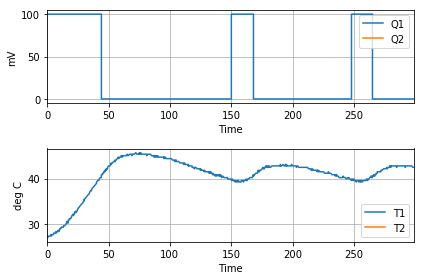

In [8]:
%matplotlib inline

import simpy.rt
import sys
sys.path.append("../TCLab")
from TCLab import TCLab

# controller coroutine with interrupt for premature ending
def control(env):
    while True:
        try:
            a.Q1 = 100 if (a.T1 <= Tsetpoint - h/2) else a.Q1
            a.Q1 = 0 if (a.T1 >= Tsetpoint + h/2) else a.Q1
            yield env.timeout(1)
        except:
            a.stop()
            
# reporter coroutine to help us monitor status
def reporter(env):
    print("\n  Time(sec)   Heater(mV)   Temp(deg C)")
    sfmt = '  {0:7.2f}      {1:7.2f}     {2:7.2f}'
    while True:
        print(sfmt.format(env.now, a.Q1, a.T1), flush=True, end='\r')
        yield env.timeout(5)

# fix the setpoint
Tsetpoint = 40.0
h = 0.5

# start up the temperature control lab
a = TCLab()
a.start()

# create the real-time simulation environment
env = simpy.rt.RealtimeEnvironment(strict=False)
env.process(control(env))
env.process(reporter(env))
env.run(until=300)

# shutdown 
a.stop()
a.plot()

## Exercises

1. Examining the closed-loop responses, it's obvious that the heater is oversized for the purpose of control at 40 deg C.  Try other values for $Q^{\max}$ to see if you can improve closed-loop performance.

2. What is the effect of sample time on control performance? What happens if you make the controller sample time longer?

3. In a new cell, create a modification of the script to include a change in setpoint from 40 deg C to 50 deg C at the 300 second mark. Run the experiment for at least 10 minutes to see the full effect.